In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Sequential
from tensorflow.python.client import device_lib


In [2]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15248484649831337755
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14053015552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7516209273988094663
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('  GPU: {}'.format([x.physical_device_desc for x in device_lib.list_local_devices() if x.device_type == 'GPU']))


Num GPUs Available:  1
  GPU: ['device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9']


In [5]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        gpus_logicas = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "GPUs físicas,", len(gpus_logicas), "GPUs lógicas")
    except RuntimeError as e:
        print(e)

1 GPUs físicas, 1 GPUs lógicas


In [6]:
image_size = (250, 250)
batch_size = 16

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "..\data\\raw_data\\image_resize",
    label_mode='categorical',
    validation_split=0.2,
    subset="both",
    shuffle=True,
    seed=666,
    image_size=image_size,
    batch_size=batch_size,
)

Found 6860 files belonging to 11 classes.
Using 5488 files for training.
Using 1372 files for validation.


In [7]:
class_names = train_ds.class_names
class_names

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

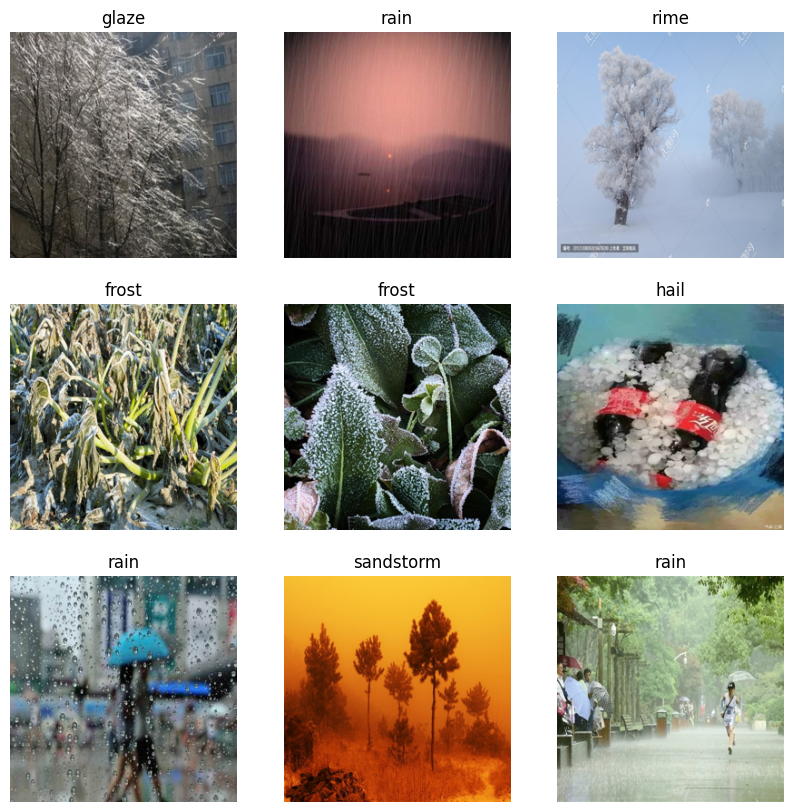

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        label_index = tf.argmax(labels[i]).numpy()
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[label_index])
        plt.axis("off")

In [10]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(250,
                                  250,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)

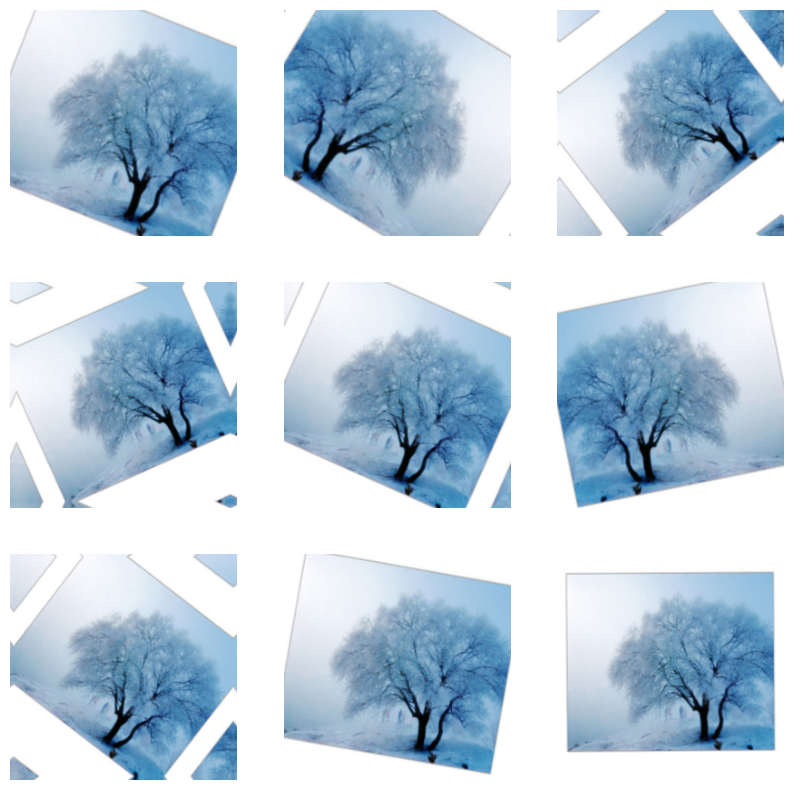

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [12]:

AUTOTUNE = tf.data.AUTOTUNE # full rend

train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [30]:
def make_model(input_shape, num_classes):
    
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [250, 250, 3]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    
    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.3)(x)
    x = keras.layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(500, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=11)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 250, 250, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 125, 125, 12  3584        ['rescaling_1[0][0]']            
                                8)                                                                
                                                                                            

In [15]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("..\\models\\deep_learning\\keras_models\\save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
344/344 [==============================] - 31s 76ms/step - loss: 1.5728 - accuracy: 0.4421 - val_loss: 3.8804 - val_accuracy: 0.1195
Epoch 2/25
344/344 [==============================] - 27s 77ms/step - loss: 1.3528 - accuracy: 0.5089 - val_loss: 1.3413 - val_accuracy: 0.5408
Epoch 3/25
344/344 [==============================] - 28s 80ms/step - loss: 1.3229 - accuracy: 0.5273 - val_loss: 1.3955 - val_accuracy: 0.4767
Epoch 4/25
344/344 [==============================] - 27s 77ms/step - loss: 1.2331 - accuracy: 0.5528 - val_loss: 2.1984 - val_accuracy: 0.3171
Epoch 5/25
344/344 [==============================] - 27s 78ms/step - loss: 1.1911 - accuracy: 0.5781 - val_loss: 1.4120 - val_accuracy: 0.5357
Epoch 6/25
344/344 [==============================] - 27s 78ms/step - loss: 1.1342 - accuracy: 0.5969 - val_loss: 1.5085 - val_accuracy: 0.4905
Epoch 7/25
344/344 [==============================] - 27s 78ms/step - loss: 1.1168 - accuracy: 0.6038 - val_loss: 1.3405 - val_accuracy:

In [33]:
from tensorflow.keras.models import load_model

final_modal = load_model("..\\models\\deep_learning\\keras_models_2\\save_at_49.keras")

<PIL.Image.Image image mode=RGB size=250x250 at 0x1AD18543C48>
1/1 [==============================] - 0s 124ms/step
[[0.06598155 0.00252697 0.0134486  0.02337505 0.35257047 0.00054723
  0.47013146 0.01013606 0.00379968 0.00260331 0.05487963]]
Clase predicha: rain


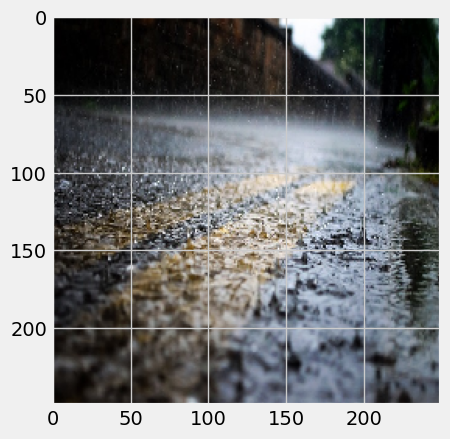

In [34]:
img = keras.utils.load_img(
    "rain_test.jpg", target_size=image_size
)
img = img.resize((250,250))
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = final_modal.predict(img_array)
predicted_label = np.argmax(predictions)
predicted_label_name = class_names[predicted_label]
print(predictions)
print("Clase predicha:", predicted_label_name)
#print(f"This image is {100 * (1 - score):.2f}% rain and {100 * score:.2f}% rest.")

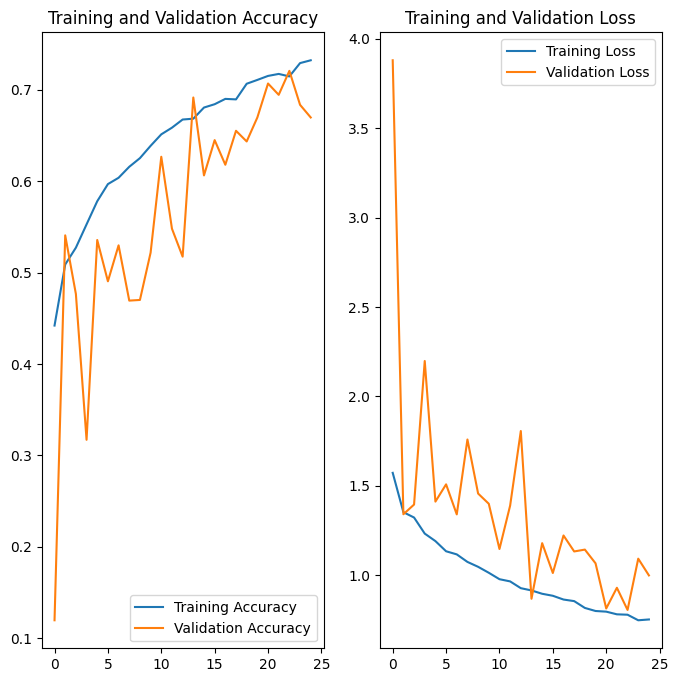

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
image_size = (250, 250)
batch_size = 16

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "..\data\\raw_data\\raw",
    label_mode='categorical',
    validation_split=0.15,
    subset="both",
    shuffle=True,
    seed=666,
    image_size=image_size,
    batch_size=batch_size,
)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(250,
                                  250,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

AUTOTUNE = tf.data.AUTOTUNE # full rend

train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)


Found 6862 files belonging to 11 classes.
Using 5833 files for training.
Using 1029 files for validation.


In [17]:
model_2 = make_model(input_shape=image_size + (3,), num_classes=11)


epochs = 100

callbacks = [
    keras.callbacks.ModelCheckpoint("..\\models\\deep_learning\\keras_models_2\\save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(patience=20)
]
model_2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model_2.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/100
365/365 [==============================] - 30s 73ms/step - loss: 1.6209 - accuracy: 0.4310 - val_loss: 3.9857 - val_accuracy: 0.1399
Epoch 2/100
365/365 [==============================] - 26s 70ms/step - loss: 1.3594 - accuracy: 0.5179 - val_loss: 2.3275 - val_accuracy: 0.3256
Epoch 3/100
365/365 [==============================] - 26s 71ms/step - loss: 1.2799 - accuracy: 0.5371 - val_loss: 1.3585 - val_accuracy: 0.5520
Epoch 4/100
365/365 [==============================] - 26s 71ms/step - loss: 1.2191 - accuracy: 0.5587 - val_loss: 1.2632 - val_accuracy: 0.5413
Epoch 5/100
365/365 [==============================] - 26s 71ms/step - loss: 1.1951 - accuracy: 0.5786 - val_loss: 1.6579 - val_accuracy: 0.4898
Epoch 6/100
365/365 [==============================] - 26s 72ms/step - loss: 1.1140 - accuracy: 0.5956 - val_loss: 1.2006 - val_accuracy: 0.5782
Epoch 7/100
365/365 [==============================] - 26s 72ms/step - loss: 1.0802 - accuracy: 0.6124 - val_loss: 1.1011 - val_ac

In [22]:
def plot_history_loss(history):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

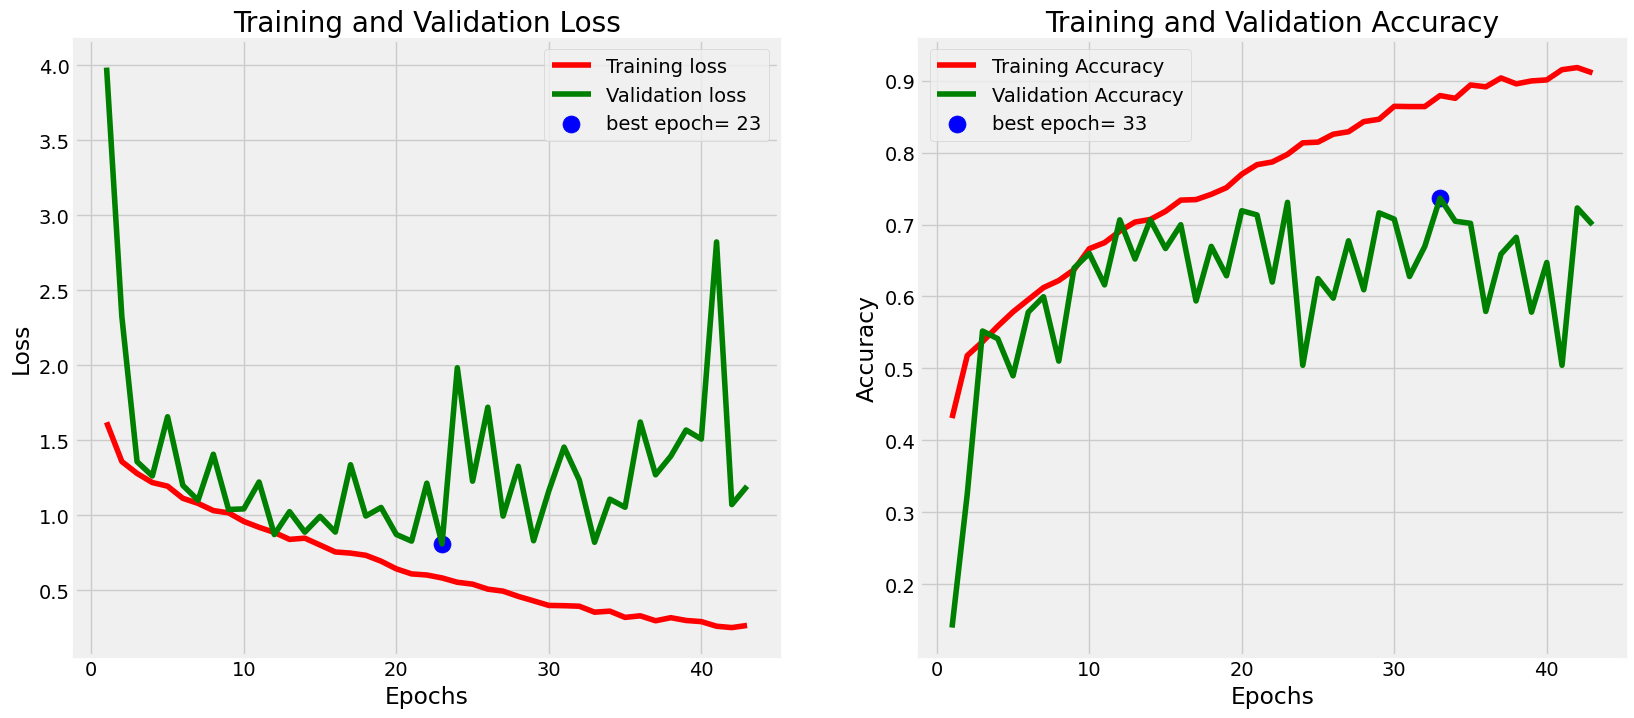

In [19]:
plot_history_loss(history)

In [20]:
val_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 11), dtype=tf.float32, name=None))>

In [21]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "..\data\\raw_data\\raw",
    label_mode='categorical',
    validation_split=0.15,
    subset="both",
    shuffle=True,
    seed=666,
    image_size=image_size,
    batch_size=batch_size,
)

Found 6862 files belonging to 11 classes.
Using 5833 files for training.
Using 1029 files for validation.


In [22]:
val_ds.class_names

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

In [23]:
val_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 11), dtype=tf.float32, name=None))>

In [24]:
X_test, y_test = [], []

for images, labels in val_ds:
    X_test.append(images.numpy())
    y_test.append(labels.numpy()) 

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_test: (1029, 250, 250, 3)
Forma de y_test: (1029, 11)


In [25]:
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
class_names_label

{'dew': 0,
 'fogsmog': 1,
 'frost': 2,
 'glaze': 3,
 'hail': 4,
 'lightning': 5,
 'rain': 6,
 'rainbow': 7,
 'rime': 8,
 'sandstorm': 9,
 'snow': 10}

In [26]:
assigned_numbers = []
for y_test_batch in y_test:
    position_of_1 = tf.argmax(y_test_batch)

    assigned_number = position_of_1.numpy()
    assigned_numbers.append(assigned_number)

print("Números asignados:", assigned_numbers)

Números asignados: [3, 2, 1, 0, 5, 3, 6, 3, 6, 4, 1, 1, 8, 8, 8, 9, 9, 4, 8, 10, 2, 0, 6, 2, 0, 4, 1, 4, 3, 10, 0, 7, 1, 7, 6, 0, 1, 1, 1, 0, 1, 0, 2, 2, 5, 2, 0, 1, 8, 2, 7, 10, 1, 8, 10, 3, 6, 8, 7, 7, 1, 2, 6, 4, 10, 1, 6, 1, 9, 6, 5, 2, 8, 4, 0, 7, 3, 4, 1, 8, 8, 8, 8, 1, 6, 3, 6, 4, 0, 10, 6, 5, 8, 8, 8, 10, 1, 8, 3, 9, 1, 8, 1, 3, 8, 1, 0, 3, 1, 8, 1, 4, 0, 8, 9, 0, 5, 10, 1, 10, 0, 4, 2, 6, 4, 2, 0, 6, 8, 6, 8, 2, 4, 6, 8, 8, 1, 9, 5, 4, 9, 4, 0, 4, 2, 7, 3, 10, 2, 1, 3, 1, 0, 3, 2, 4, 1, 9, 6, 8, 8, 1, 6, 1, 10, 9, 8, 10, 4, 0, 9, 9, 2, 8, 4, 0, 6, 0, 8, 3, 10, 8, 5, 10, 8, 7, 1, 6, 8, 7, 10, 9, 10, 9, 6, 0, 4, 2, 3, 8, 3, 8, 2, 5, 1, 8, 7, 1, 3, 1, 6, 6, 0, 6, 1, 8, 1, 6, 5, 3, 8, 9, 0, 10, 1, 7, 5, 10, 4, 3, 5, 3, 10, 9, 8, 10, 0, 3, 3, 1, 10, 9, 3, 8, 0, 8, 2, 8, 0, 9, 2, 3, 0, 9, 1, 6, 2, 9, 10, 8, 1, 1, 3, 0, 8, 8, 1, 0, 0, 10, 8, 3, 1, 3, 3, 9, 5, 2, 10, 3, 1, 3, 0, 1, 9, 8, 10, 9, 9, 8, 4, 1, 2, 10, 7, 8, 0, 8, 5, 2, 3, 8, 6, 6, 0, 5, 4, 9, 6, 8, 9, 8, 10, 9, 4, 6, 2, 6,

In [27]:
X_test_nor = X_test/255


In [28]:
y_pred = model_2.predict(X_test)
y_pred

33/33 [==============================] - 1s 31ms/step


array([[6.1711129e-02, 5.5919547e-04, 1.3027290e-01, ..., 1.9528959e-02,
        2.9488036e-04, 5.3596282e-03],
       [2.1954870e-02, 1.4544705e-02, 5.4545417e-02, ..., 2.7945521e-01,
        9.5533459e-03, 1.4437242e-01],
       [8.2774676e-07, 9.9097061e-01, 4.5225276e-10, ..., 8.7563121e-06,
        8.9482898e-03, 5.2741336e-07],
       ...,
       [7.5027137e-04, 6.5956720e-09, 9.9598253e-01, ..., 2.7958656e-04,
        1.4323573e-09, 2.0192449e-07],
       [2.4404975e-02, 1.0070887e-04, 1.7157603e-03, ..., 3.1381717e-04,
        2.0259791e-05, 1.1518041e-03],
       [4.1616431e-07, 3.1999651e-02, 7.4535660e-07, ..., 4.1164439e-02,
        3.1326046e-05, 9.2477888e-01]], dtype=float32)

In [29]:
results = model_2.evaluate(X_test, y_test)
results

33/33 [==============================] - 1s 36ms/step - loss: 1.1948 - accuracy: 0.6997


[1.1947860717773438, 0.6997084617614746]

In [30]:
pred_labels = np.argmax(y_pred, axis=1)
label_pred = [class_names[pred] for pred in pred_labels]
label_pred

['glaze',
 'glaze',
 'fogsmog',
 'fogsmog',
 'lightning',
 'rime',
 'rain',
 'glaze',
 'fogsmog',
 'hail',
 'fogsmog',
 'fogsmog',
 'rime',
 'fogsmog',
 'rainbow',
 'sandstorm',
 'sandstorm',
 'hail',
 'rime',
 'rime',
 'rime',
 'dew',
 'fogsmog',
 'glaze',
 'dew',
 'hail',
 'fogsmog',
 'hail',
 'snow',
 'snow',
 'dew',
 'rainbow',
 'fogsmog',
 'rainbow',
 'rain',
 'dew',
 'fogsmog',
 'fogsmog',
 'fogsmog',
 'rain',
 'fogsmog',
 'dew',
 'rime',
 'frost',
 'lightning',
 'frost',
 'dew',
 'fogsmog',
 'rime',
 'rime',
 'rainbow',
 'rain',
 'fogsmog',
 'rime',
 'snow',
 'glaze',
 'rain',
 'rime',
 'rainbow',
 'sandstorm',
 'fogsmog',
 'frost',
 'rain',
 'hail',
 'snow',
 'fogsmog',
 'fogsmog',
 'fogsmog',
 'sandstorm',
 'fogsmog',
 'rainbow',
 'dew',
 'rime',
 'hail',
 'dew',
 'rainbow',
 'hail',
 'hail',
 'fogsmog',
 'rime',
 'rime',
 'rime',
 'glaze',
 'fogsmog',
 'rain',
 'rime',
 'rain',
 'hail',
 'dew',
 'snow',
 'rain',
 'lightning',
 'snow',
 'snow',
 'rime',
 'snow',
 'fogsmog',
 '

<AxesSubplot:>

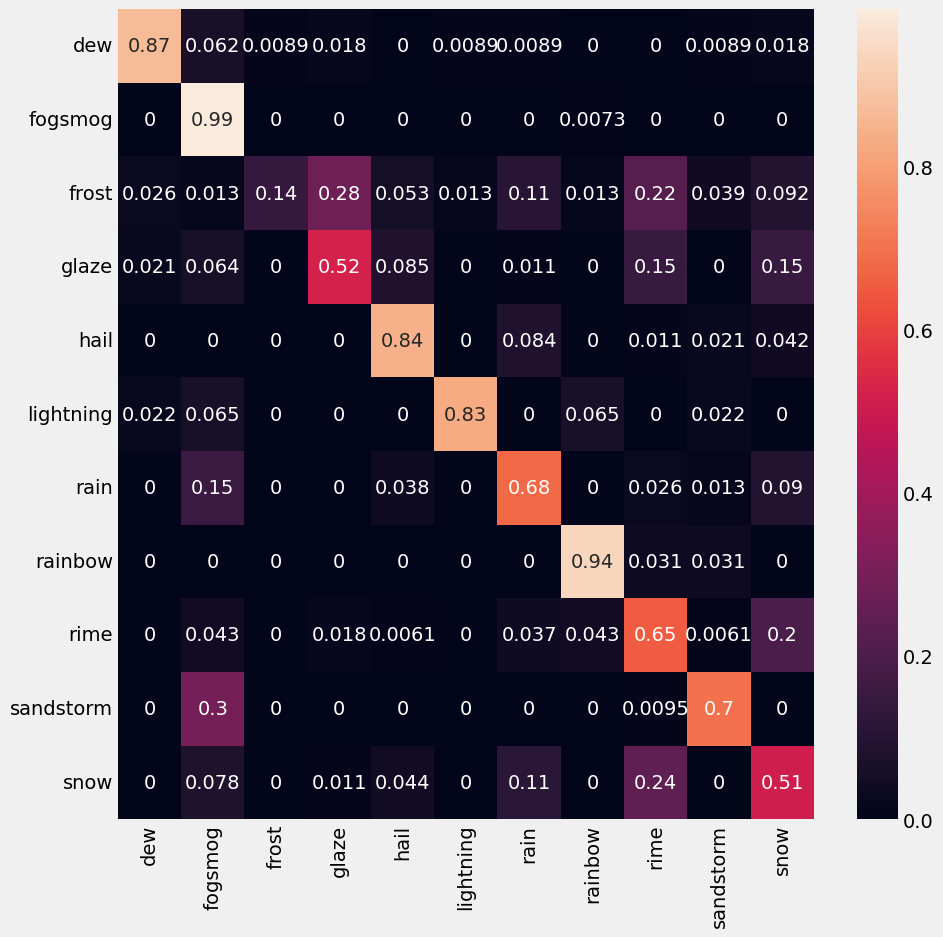

In [31]:
plt.figure(figsize=(10,10))
c_mat = confusion_matrix(assigned_numbers, pred_labels, normalize='true')
sns.heatmap(c_mat, annot=True, xticklabels=class_names, yticklabels=class_names)

In [37]:
image_size = (250, 250)
batch_size = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "..\data\\raw_data\\raw",
    label_mode='categorical',
    validation_split=0.15,
    subset="both",
    shuffle=True,
    seed=666,
    image_size=image_size,
    batch_size=batch_size,
)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(250,
                                  250,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

AUTOTUNE = tf.data.AUTOTUNE # full rend

train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Found 6862 files belonging to 11 classes.
Using 5833 files for training.
Using 1029 files for validation.


In [38]:
model_2_1 = make_model(input_shape=image_size + (3,), num_classes=11)


epochs = 100

callbacks = [
    keras.callbacks.ModelCheckpoint("..\\models\\deep_learning\\keras_models_2\\save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(patience=20)
]
model_2_1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model_2_1.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/100
183/183 [==============================] - 30s 161ms/step - loss: 1.6566 - accuracy: 0.4236 - val_loss: 3.5562 - val_accuracy: 0.1895
Epoch 2/100
183/183 [==============================] - 29s 159ms/step - loss: 1.3460 - accuracy: 0.5239 - val_loss: 3.9926 - val_accuracy: 0.1730
Epoch 3/100
183/183 [==============================] - 29s 158ms/step - loss: 1.2317 - accuracy: 0.5549 - val_loss: 2.4774 - val_accuracy: 0.2799
Epoch 4/100
183/183 [==============================] - 30s 161ms/step - loss: 1.1620 - accuracy: 0.5884 - val_loss: 1.4383 - val_accuracy: 0.5160
Epoch 5/100
183/183 [==============================] - 30s 162ms/step - loss: 1.0987 - accuracy: 0.6023 - val_loss: 1.3036 - val_accuracy: 0.5364
Epoch 6/100
183/183 [==============================] - 30s 163ms/step - loss: 1.0611 - accuracy: 0.6168 - val_loss: 1.0702 - val_accuracy: 0.6356
Epoch 7/100
183/183 [==============================] - 29s 159ms/step - loss: 1.0099 - accuracy: 0.6420 - val_loss: 1.0934 -

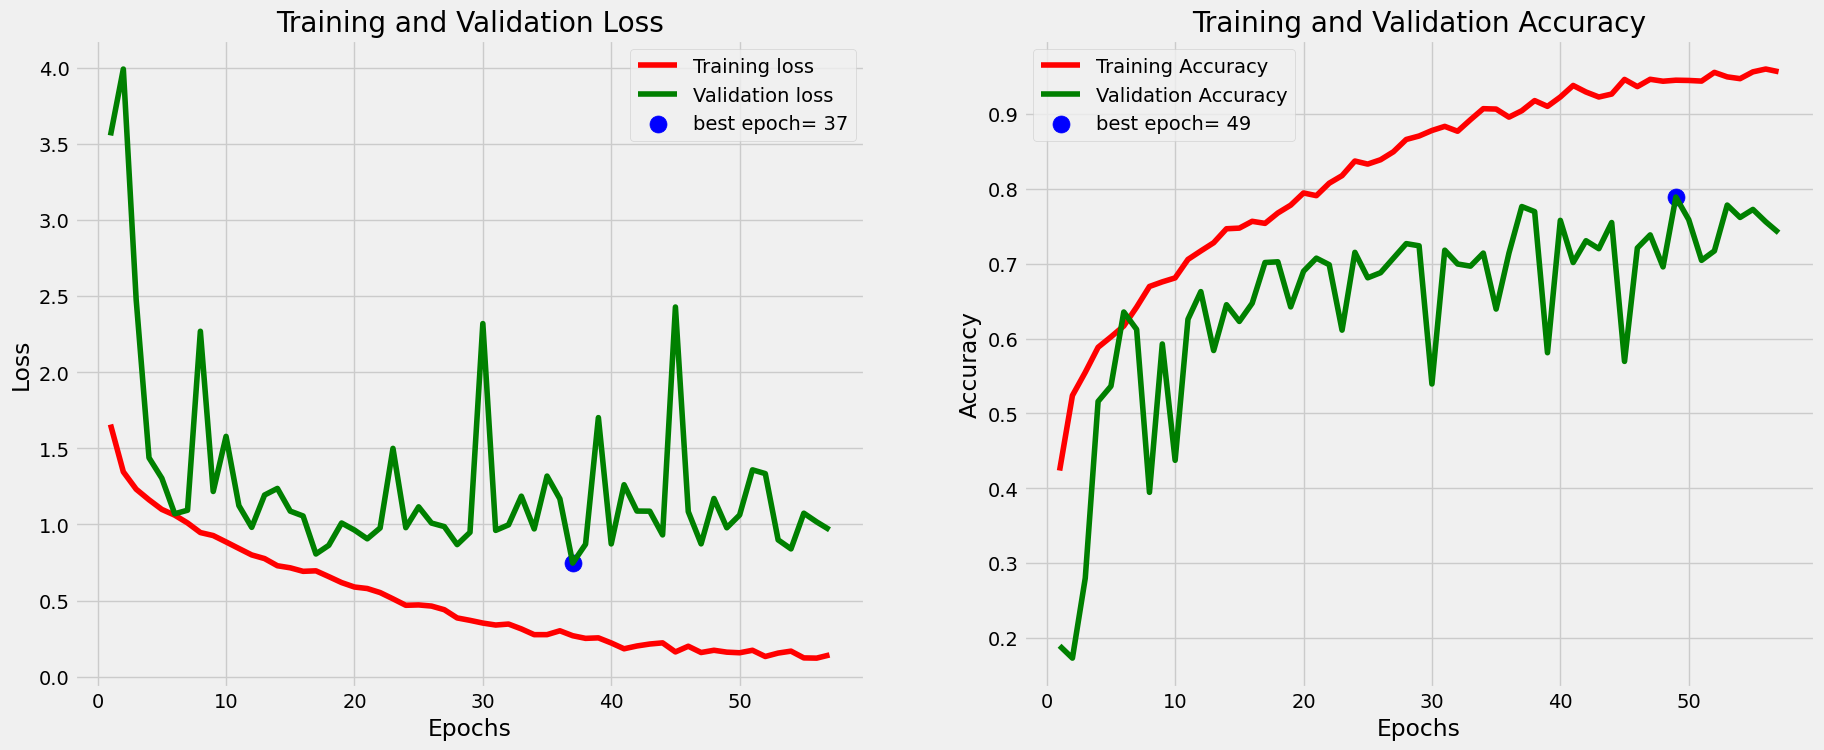

In [39]:
plot_history_loss(history)

In [41]:
X_test, y_test = [], []

for images, labels in val_ds:
    X_test.append(images.numpy())
    y_test.append(labels.numpy()) 

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test.shape)

assigned_numbers = []
for y_test_batch in y_test:
    position_of_1 = tf.argmax(y_test_batch)

    assigned_number = position_of_1.numpy()
    assigned_numbers.append(assigned_number)

y_pred = model_2_1.predict(X_test)
results = model_2_1.evaluate(X_test, y_test)
print(results)


Forma de X_test: (1029, 250, 250, 3)
Forma de y_test: (1029, 11)
33/33 [==============================] - 2s 49ms/step - loss: 0.9654 - accuracy: 0.7415
[0.9653502106666565, 0.7414966225624084]


<AxesSubplot:>

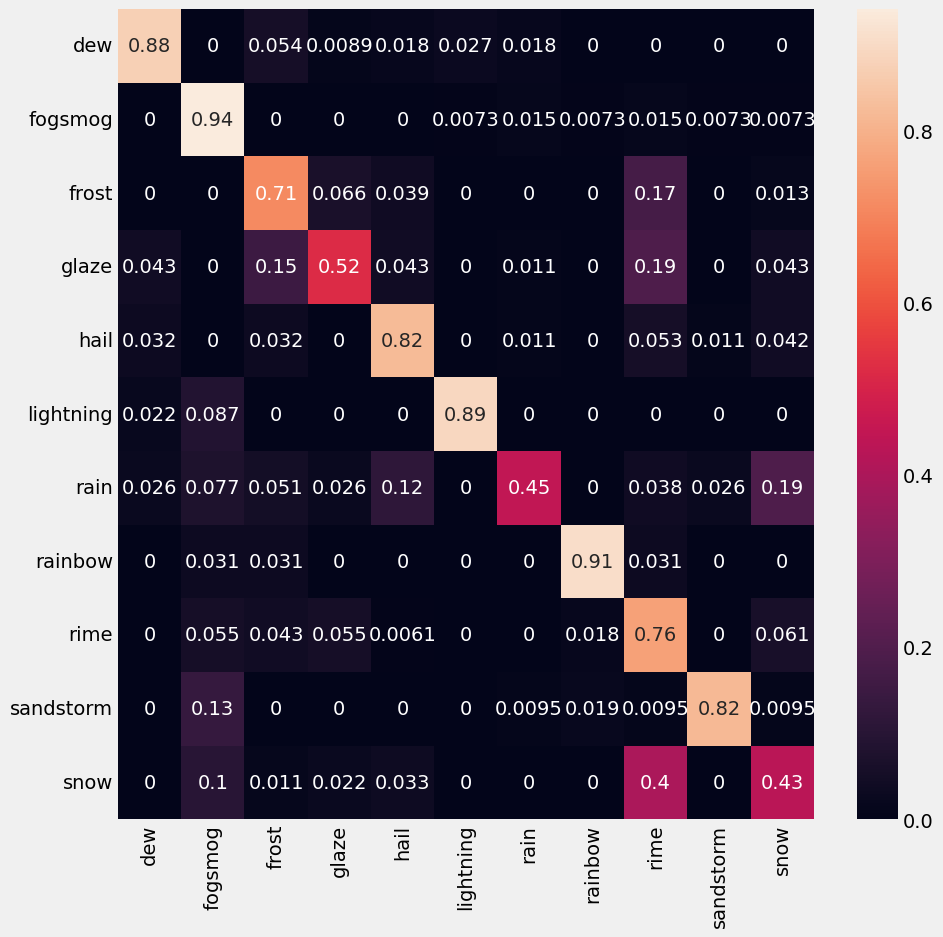

In [42]:
pred_labels = np.argmax(y_pred, axis=1)
label_pred = [class_names[pred] for pred in pred_labels]

plt.figure(figsize=(10,10))
c_mat = confusion_matrix(assigned_numbers, pred_labels, normalize='true')
sns.heatmap(c_mat, annot=True, xticklabels=class_names, yticklabels=class_names)

In [19]:
image_size = (250, 250)
batch_size = 48

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "..\data\\raw_data\\raw",
    label_mode='categorical',
    validation_split=0.15,
    subset="both",
    shuffle=True,
    seed=666,
    image_size=image_size,
    batch_size=batch_size,
)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(250,
                                  250,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

AUTOTUNE = tf.data.AUTOTUNE # full rend

train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Found 6862 files belonging to 11 classes.
Using 5833 files for training.
Using 1029 files for validation.


In [20]:
model_2_2 = make_model(input_shape=image_size + (3,), num_classes=11)


epochs = 15

callbacks = [
    keras.callbacks.ModelCheckpoint("..\\models\\deep_learning\\keras_models_2_2\\save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(patience=20)
]
model_2_2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model_2_2.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/15
122/122 [==============================] - 143s 1s/step - loss: 1.5799 - accuracy: 0.4445 - val_loss: 2.8209 - val_accuracy: 0.1846
Epoch 2/15
122/122 [==============================] - 139s 1s/step - loss: 1.3200 - accuracy: 0.5181 - val_loss: 4.8197 - val_accuracy: 0.1331
Epoch 3/15
122/122 [==============================] - 139s 1s/step - loss: 1.2374 - accuracy: 0.5585 - val_loss: 4.9826 - val_accuracy: 0.1924
Epoch 4/15
122/122 [==============================] - 139s 1s/step - loss: 1.1217 - accuracy: 0.5904 - val_loss: 2.9286 - val_accuracy: 0.1953
Epoch 5/15
122/122 [==============================] - 139s 1s/step - loss: 1.0678 - accuracy: 0.6192 - val_loss: 2.0683 - val_accuracy: 0.3926
Epoch 6/15
122/122 [==============================] - 139s 1s/step - loss: 1.0229 - accuracy: 0.6287 - val_loss: 1.2868 - val_accuracy: 0.5500
Epoch 7/15
122/122 [==============================] - 173s 1s/step - loss: 0.9756 - accuracy: 0.6513 - val_loss: 1.2704 - val_accuracy: 0.5462

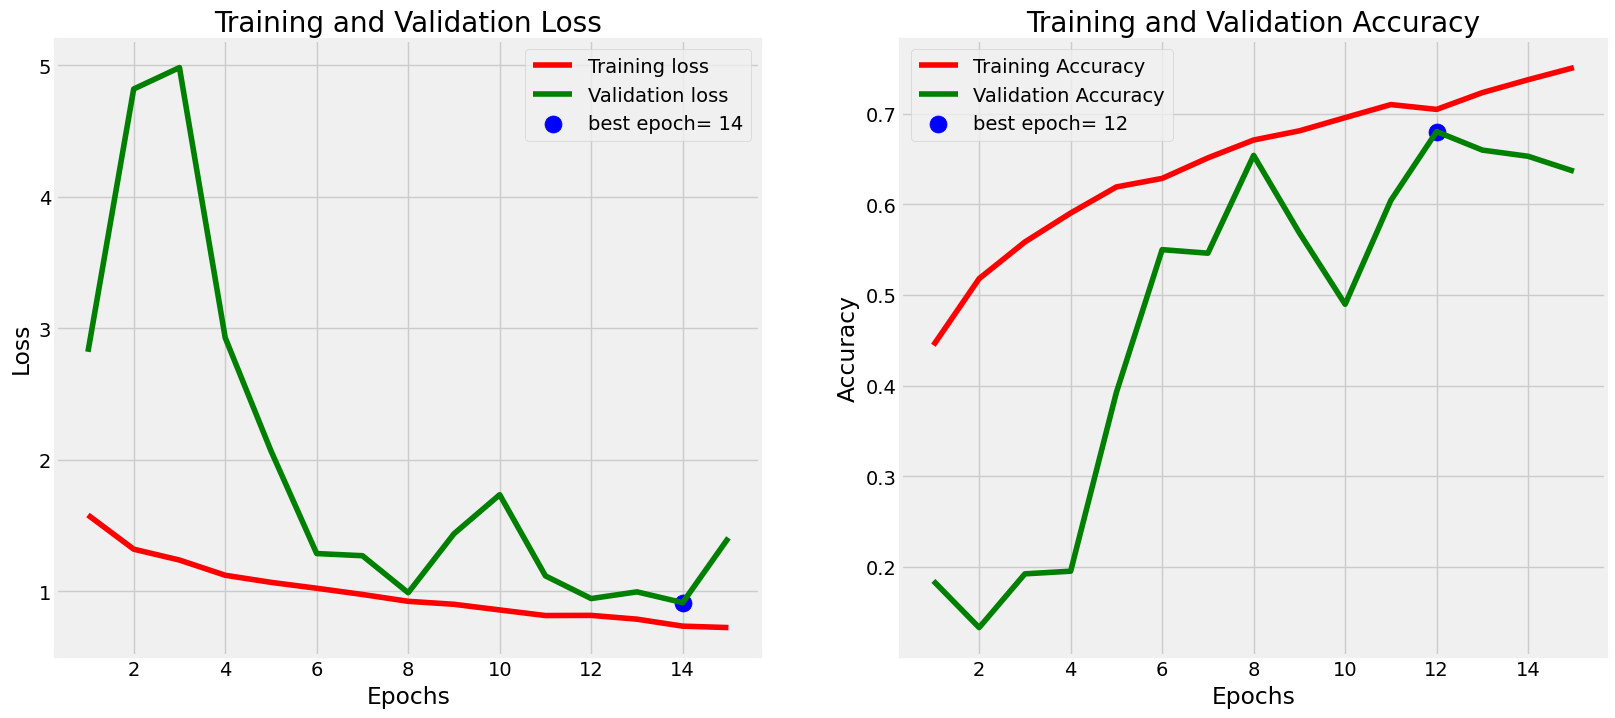

In [23]:
plot_history_loss(history)

In [25]:
X_test, y_test = [], []

for images, labels in val_ds:
    X_test.append(images.numpy())
    y_test.append(labels.numpy()) 

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test.shape)

assigned_numbers = []
for y_test_batch in y_test:
    position_of_1 = tf.argmax(y_test_batch)

    assigned_number = position_of_1.numpy()
    assigned_numbers.append(assigned_number)

y_pred = model_2_2.predict(X_test)
results = model_2_2.evaluate(X_test, y_test)
print(results)


Forma de X_test: (1029, 250, 250, 3)
Forma de y_test: (1029, 11)
33/33 [==============================] - 3s 92ms/step - loss: 1.4063 - accuracy: 0.6365
[1.4063230752944946, 0.6365403532981873]


<AxesSubplot:>

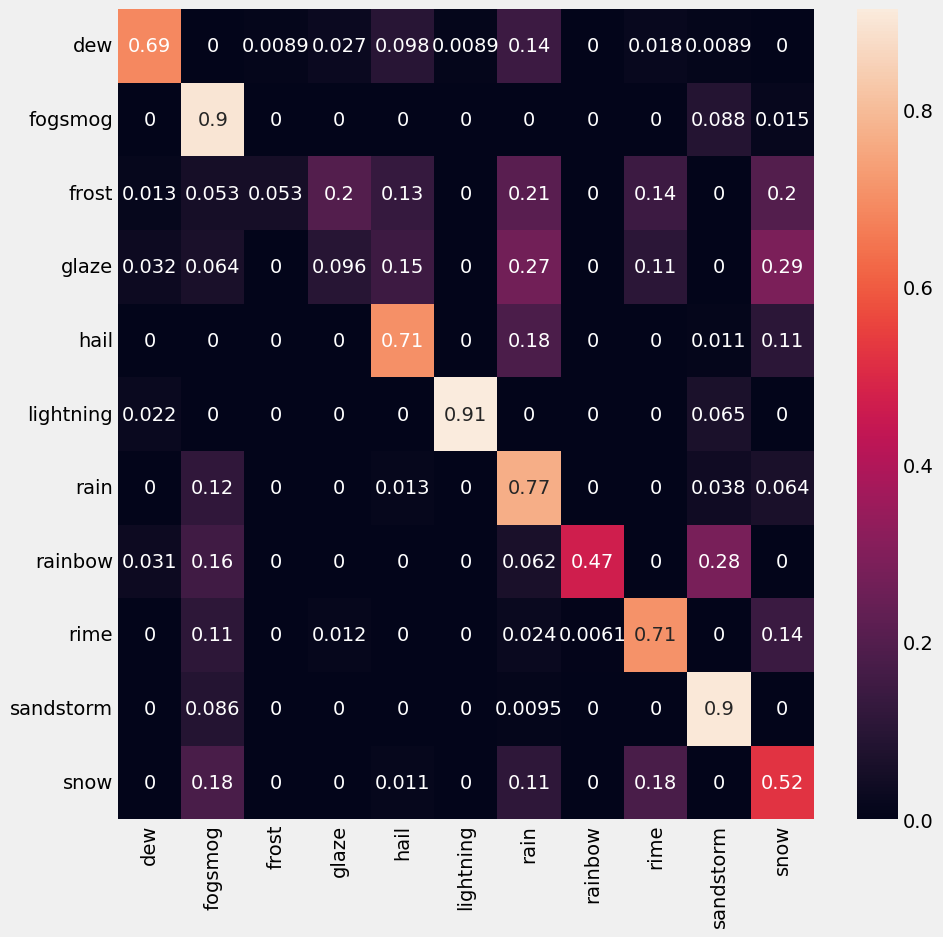

In [26]:
pred_labels = np.argmax(y_pred, axis=1)
label_pred = [class_names[pred] for pred in pred_labels]

plt.figure(figsize=(10,10))
c_mat = confusion_matrix(assigned_numbers, pred_labels, normalize='true')
sns.heatmap(c_mat, annot=True, xticklabels=class_names, yticklabels=class_names)

In [108]:
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu" , input_shape = (250,250,3)) ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256,(3,3),activation = "relu" , input_shape = (250,250,3)) ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(550,activation="relu"),   
    tf.keras.layers.Dropout(0.1,seed = 2019),
    tf.keras.layers.Dense(400,activation ="relu"),
    tf.keras.layers.Dropout(0.3,seed = 2019),
    tf.keras.layers.Dense(300,activation="relu"),
    tf.keras.layers.Dropout(0.4,seed = 2019),
    tf.keras.layers.Dense(200,activation ="relu"),
    tf.keras.layers.Dropout(0.2,seed = 2019),
    tf.keras.layers.Dense(11,activation = "softmax")  
])

In [109]:
image_size = (250, 250)
batch_size = 64

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "..\data\\raw_data\\image_resize",
    label_mode='categorical',
    validation_split=0.15,
    subset="both",
    shuffle=True,
    seed=666,
    image_size=image_size,
    batch_size=batch_size,
)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(250,
                                  250,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)

AUTOTUNE = tf.data.AUTOTUNE # full rend

train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Found 6862 files belonging to 11 classes.
Using 5833 files for training.
Using 1029 files for validation.


In [110]:

epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("..\\models\\deep_learning\\keras_models_3\\save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(patience=20)
]
model_3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model_3.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/20


92/92 [==============================] - 50s 526ms/step - loss: 2.1921 - accuracy: 0.2757 - val_loss: 1.6591 - val_accuracy: 0.4684
Epoch 2/20
92/92 [==============================] - 48s 520ms/step - loss: 1.6493 - accuracy: 0.4418 - val_loss: 1.4875 - val_accuracy: 0.4927
Epoch 3/20
92/92 [==============================] - 47s 513ms/step - loss: 1.5018 - accuracy: 0.4980 - val_loss: 1.5821 - val_accuracy: 0.5121
Epoch 4/20
92/92 [==============================] - 47s 515ms/step - loss: 1.3752 - accuracy: 0.5275 - val_loss: 1.2787 - val_accuracy: 0.5374
Epoch 5/20
92/92 [==============================] - 47s 513ms/step - loss: 1.2983 - accuracy: 0.5495 - val_loss: 1.2593 - val_accuracy: 0.5705
Epoch 6/20
92/92 [==============================] - 47s 511ms/step - loss: 1.2374 - accuracy: 0.5723 - val_loss: 1.3136 - val_accuracy: 0.5452
Epoch 7/20
92/92 [==============================] - 47s 512ms/step - loss: 1.2006 - accuracy: 0.5899 - val_loss: 1.1324 - val_accuracy: 0.5986
Epoch 8/20

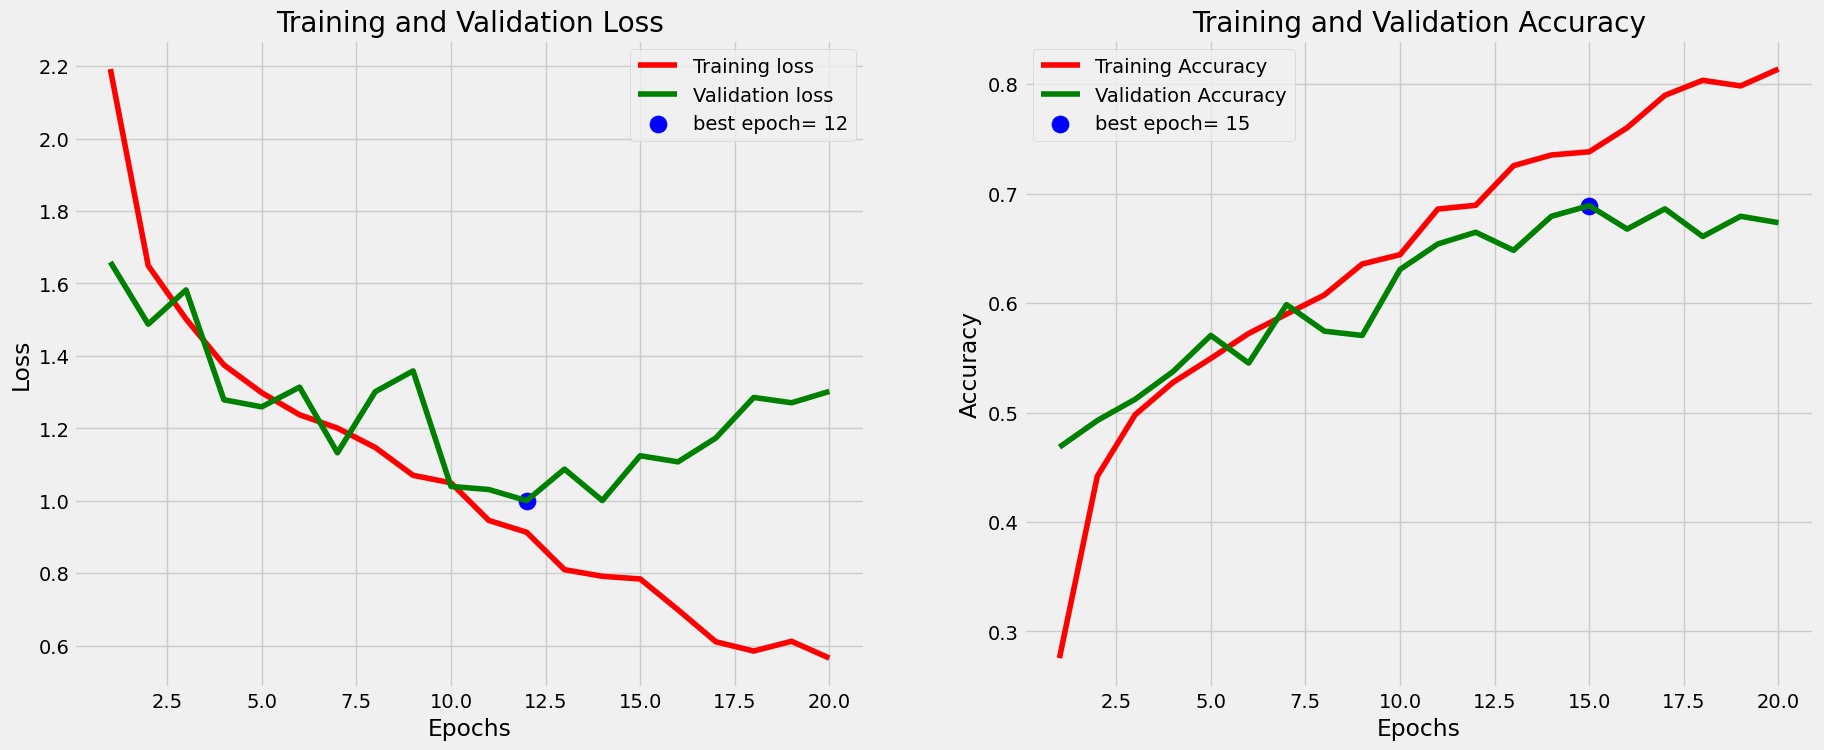

In [114]:
plot_history_loss(history)

In [120]:
X_test, y_test = [], []

for images, labels in val_ds:
    X_test.append(images.numpy())
    y_test.append(labels.numpy()) 

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test.shape)

assigned_numbers = []
for y_test_batch in y_test:
    position_of_1 = tf.argmax(y_test_batch)

    assigned_number = position_of_1.numpy()
    assigned_numbers.append(assigned_number)

y_pred = model_2.predict(X_test)
results = model_2.evaluate(X_test, y_test)
print(results)



Forma de X_test: (1029, 250, 250, 3)
Forma de y_test: (1029, 11)
33/33 [==============================] - 19s 589ms/step - loss: 1.1048 - accuracy: 0.7133
[1.1048344373703003, 0.71331387758255]


<AxesSubplot:>

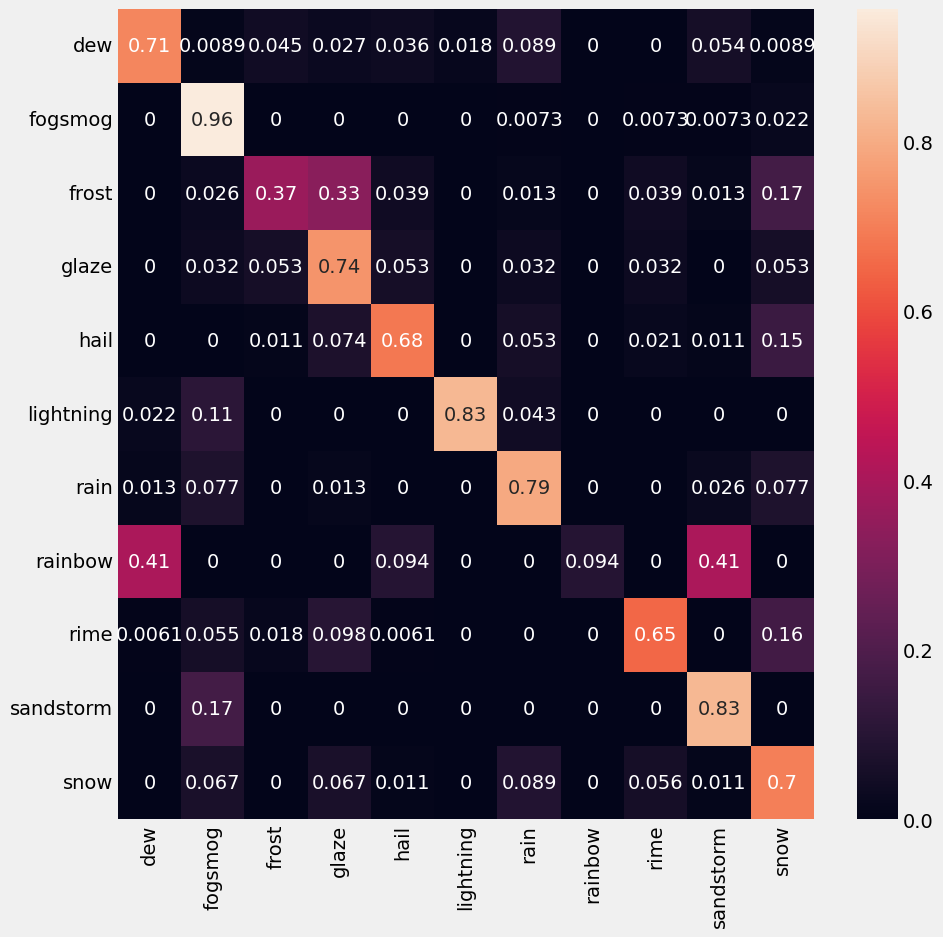

In [121]:

pred_labels = np.argmax(y_pred, axis=1)
label_pred = [class_names[pred] for pred in pred_labels]

plt.figure(figsize=(10,10))
c_mat = confusion_matrix(assigned_numbers, pred_labels, normalize='true')
sns.heatmap(c_mat, annot=True, xticklabels=class_names, yticklabels=class_names)

In [33]:
from tensorflow.keras.models import load_model

final_modal = load_model("..\\models\\deep_learning\\keras_models_2\\save_at_49.keras")

In [35]:
class_names

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

1/1 [==============================] - 0s 112ms/step
[[1.3668375e-02 4.9585104e-04 1.1571287e-01 3.4241301e-03 2.0935582e-02
  7.0761133e-04 8.3167142e-01 1.4784308e-03 6.6297606e-04 8.4958388e-04
  1.0393256e-02]]
Clase predicha: rain


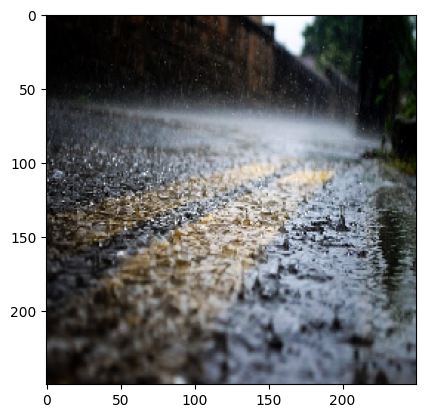

In [34]:
img = keras.utils.load_img(
    "rain_test.jpg", target_size=(250,250)
)
img = img.resize((250,250))
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = final_modal.predict(img_array)
predicted_label = np.argmax(predictions)
predicted_label_name = class_names[predicted_label]
print(predictions)
print("Clase predicha:", predicted_label_name)


In [15]:
class_names


['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

In [36]:
def evaluate_img(image, model, class_names):
    """
    Evaluates an image using a trained Keras model and displays the image with predictions.

    Parameters:
    - img: The input image to be evaluated.
    - model (tf.keras.Model): The trained Keras model.
    - class_names (list): A list of class names corresponding to the model's output classes.

    Returns:
    - np.ndarray: Predictions for each class.
    - str: Predicted label name.

    Example:
    ```python
    predictions, predicted_label_name = evaluate_img(input_image, trained_model, class_names)
    ```

    The `evaluate_img` function performs the following operations:
    1. Resizes the input image to the required size (250x250).
    2. Displays the resized image using Matplotlib.
    3. Converts the image to a NumPy array and adds an extra dimension.
    4. Uses the trained model to predict the class probabilities.
    5. Identifies the predicted label and its corresponding class name.

    Note:
    - Assumes that TensorFlow (`tf`), Keras (`keras`), Matplotlib (`plt`), and NumPy (`np`) have been installed.

    """
    image.save(f"test.{image.format}")

    img = keras.utils.load_img(
        f"test.{image.format}", target_size=(250,250)
    )
    img = img.resize((250,250))
    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = final_modal.predict(img_array)
    predicted_label = np.argmax(predictions)
    predicted_label_name = class_names[predicted_label]

    return predictions, predicted_label_name

In [37]:
from PIL import Image

image = Image.open("rain_test.jpg")

predictions, predicted_label_name = evaluate_img(image,final_modal,class_names)
predicted_label_name


1/1 [==============================] - 0s 10ms/step


'rain'